<a href="https://colab.research.google.com/github/emielol/House-Prices-Prediction/blob/master/improvedhousepricepredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Credits to mathurmudit2022 on Kaggle. I would like to acknowledge mathurmudit2022 for their Kaggle notebook titled 'Advanced Stacking Regressor

Their work provided me guidance for building my model.

Also credits to gusthema. Taught me a lot about TensorFlow and used some of their code in mine

In [ ]:
pip install tensorflow

In [ ]:
!pip install tensorflow_decision_forests

In [ ]:
# importing necessary stuff to get this going
import tensorflow as tf
import tensorflow_decision_forests as tfdf
from pandas.core.groupby.generic import DataFrameGroupBy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# reading dataset into program
data = pd.read_csv('/content/drive/MyDrive/datasets/train-housepredit.csv')
test_data = pd.read_csv('/content/drive/MyDrive/datasets/test-housepredict.csv')


In [ ]:
# Seeing what the first five rows look like
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Processing and cleaning data

duplicates = data.duplicated()

# Then removing any null values- if there are any
num_null = len(data.index) - len(data.dropna(how='any',axis=0).index)

#Dropping ID and Index because it has no use in training and testing. Willcneed to do the same for the testing data later
train_ID = data['Id']
test_ID = test_data['Id']
data.drop("Id", axis = 1, inplace = True)
test_data.drop("Id", axis = 1, inplace = True)



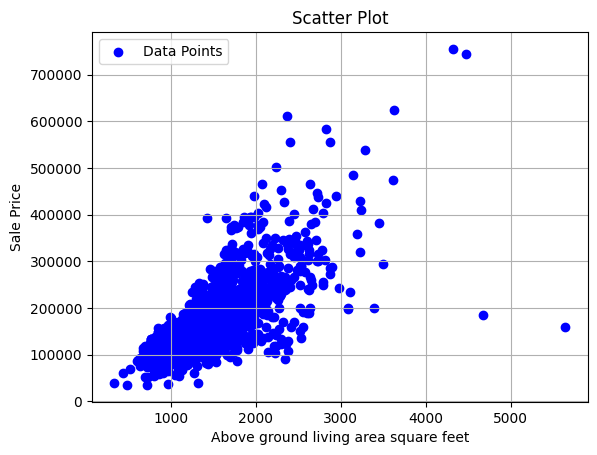

In [ ]:
# Create a scatter plot
plt.scatter( data['GrLivArea'], data['SalePrice'],c='blue', marker='o', label='Data Points')
plt.title('Scatter Plot')
plt.ylabel('Sale Price')
plt.xlabel('Above ground living area square feet')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Seems there are four outliers. Gonna remove them
price_threshold = 700000
living_area_threshold = 4500
data = data[data['SalePrice'] <= price_threshold]
data = data[data['GrLivArea'] <= living_area_threshold]

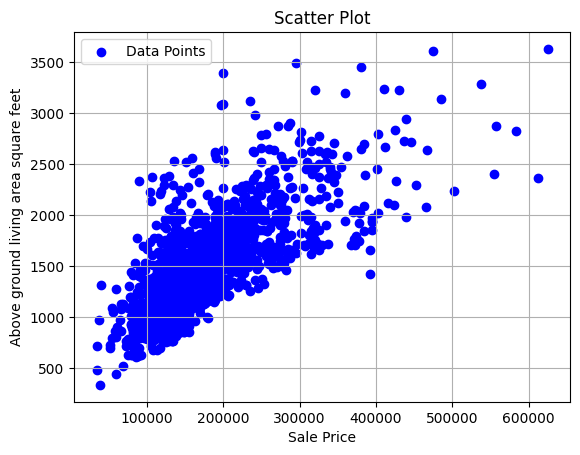

In [ ]:
# Checking again
plt.scatter(data['SalePrice'], data['GrLivArea'], c='blue', marker='o', label='Data Points')
plt.title('Scatter Plot')
plt.xlabel('Sale Price')
plt.ylabel('Above ground living area square feet')
plt.legend()
plt.grid(True)
plt.show()


There are are around 80 features in the dataset 😢 There's no way I am using all of them since some of the features barely have any weight to them.

 If I'm going to select certain features, I have to do the same in the test data


In [ ]:
# Combining the test and train dataset
num_train = data.shape[0]
num_test = test_data.shape[0]
y_train = data.SalePrice.values
combined_data = pd.concat((data, test_data)).reset_index(drop=True)
combined_data.drop(['SalePrice'], axis=1, inplace=True)
print("The size of the combined dataset is is : {}".format(combined_data.shape))

The size of the combined dataset is is : (2915, 79)


I think I'm going to choose the features based on


*   Missing data
*   Variance




In [ ]:
# Splitting the dataset

def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_data, testing_data = split_dataset(data)
print("{} training examples & {} testing examples :)".format(
    len(train_data), len(testing_data)))

1025 training examples & 431 testing examples :)


In [ ]:
label = "SalePrice"
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label=label, task = tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(testing_data, label=label, task = tfdf.keras.Task.REGRESSION)

In [ ]:
# Configuring
rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)

Resolve hyper-parameter template "benchmark_rank1" to "benchmark_rank1@v1" -> {'winner_take_all': True, 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use /tmp/tmpuewburdp as temporary training directory


In [ ]:
# Creating a random forest with TensorFlow and having evaluation metrics for it
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmp2ur0dk4t as temporary training directory


And finally...
#TRAINING THE MODEL

In [ ]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:22.530834. Found 1025 examples.
Training model...
Model trained in 0:00:09.314738
Compiling model...
Model compiled.


In [ ]:
# Now seeing how it looks
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

In [ ]:
# Now evaluating the model
evaluation = rf.evaluate(x=test_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - mse: 715565504.0000
loss: 0.0000
mse: 715565504.0000


1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - mse: 715565504.0000
[0.0, 715565504.0]
